### Face Recognition

Part I: Data Preprocessing and Visualization
- Import the data "Images.npy" - Split the images and their mask into two objects - Resize the images and masks to the same shape and visualize the original and masked images - Split the data into train and test

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd '/content/drive/MyDrive/AIML/projects/ComputerVison/FaceRecognition/'

/content/drive/MyDrive/AIML/projects/ComputerVison/FaceRecognition


Unzip files

In [4]:
!unzip /content/drive/MyDrive/AIML/projects/ComputerVison/FaceRecognition/training_images-20211126T092819Z-001.zip

Archive:  /content/drive/MyDrive/AIML/projects/ComputerVison/FaceRecognition/training_images-20211126T092819Z-001.zip
replace training_images/real_00947.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: training_images/real_00947.jpg  
replace training_images/real_01052.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: training_images/real_01052.jpg  
  inflating: training_images/real_01042.jpg  
  inflating: training_images/real_00964.jpg  
  inflating: training_images/real_01053.jpg  
  inflating: training_images/real_00971.jpg  
  inflating: training_images/real_01057.jpg  
  inflating: training_images/real_01044.jpg  
  inflating: training_images/real_01041.jpg  
  inflating: training_images/real_01067.jpg  
  inflating: training_images/real_00969.jpg  
  inflating: training_images/real_00956.jpg  
  inflating: training_images/real_00975.jpg  
  inflating: training_images/real_01021.jpg  
  inflating: training_images/real_00945.jpg  
  inflating: training_images/rea

In [19]:
ls

Benedict+Cumberbatch9.jpg  Images.npy                                vgg_face_weights.h5
Dwayne+Johnson4.jpg        training_images/
FaceRecognition.ipynb      training_images-20211126T092819Z-001.zip


Import Libraries

In [20]:
import os
import sys
import random

import numpy as np
import pandas as pd
import tensorflow as tf


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.python.keras import losses

from keras.models import Model, load_model
from keras.optimizers import Adam

Convert npy files to ndarray

In [21]:
data=np.load('./Images.npy',allow_pickle=True)
data.shape


(393, 2)

In [22]:
images = data[:,0]
mask = data[:,1]
print(images.shape, mask.shape)

(393,) (393,)


In [23]:
print(images[0])

[[[42 37 34]
  [56 51 48]
  [71 66 63]
  ...
  [23 33 34]
  [26 36 37]
  [28 38 39]]

 [[40 35 32]
  [51 46 43]
  [64 59 56]
  ...
  [27 36 35]
  [24 33 32]
  [26 35 34]]

 [[43 38 35]
  [51 46 43]
  [61 56 53]
  ...
  [28 30 27]
  [33 35 32]
  [35 37 34]]

 ...

 [[56 47 40]
  [57 48 41]
  [61 52 45]
  ...
  [67 48 42]
  [55 35 28]
  [60 40 33]]

 [[53 44 37]
  [54 45 38]
  [57 48 41]
  ...
  [59 40 34]
  [60 40 33]
  [54 34 27]]

 [[53 44 37]
  [54 45 38]
  [57 48 41]
  ...
  [59 40 34]
  [70 50 43]
  [64 44 37]]]


No of images :393

Plot two images to view sample images

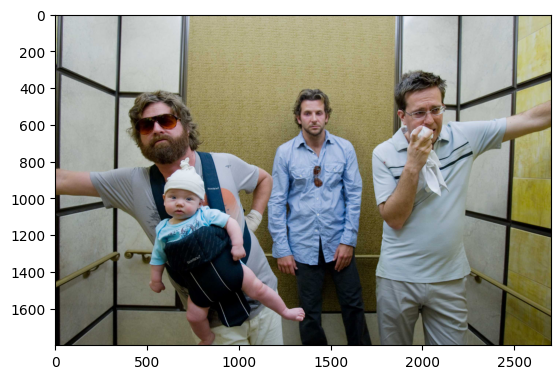

In [24]:
plt.imshow(images[111])


In [25]:
mask[111][0]

{'label': ['Face'],
 'notes': '',
 'points': [{'x': 0.7107438016528925, 'y': 0.24806201550387597},
  {'x': 0.7933884297520661, 'y': 0.37829457364341085}],
 'imageWidth': 2700,
 'imageHeight': 1800}

Define Image Height and Image Width

In [26]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
ALPHA = 1

In [27]:
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
imagedata = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    imagedata[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [28]:
imagedata.shape

(393, 224, 224, 3)

In [29]:
masks.shape

(393, 224, 224)

[[[-0.95294118 -0.67058825 -0.56078434]
  [-0.95294118 -0.67058825 -0.56078434]
  [-0.95294118 -0.67058825 -0.56078434]
  ...
  [-0.92941177 -0.63137257 -0.52941179]
  [-0.92941177 -0.63137257 -0.52941179]
  [-0.92941177 -0.63137257 -0.52941179]]

 [[-0.95294118 -0.67058825 -0.56078434]
  [-0.95294118 -0.67058825 -0.56078434]
  [-0.95294118 -0.67058825 -0.56078434]
  ...
  [-0.92941177 -0.63137257 -0.52941179]
  [-0.92941177 -0.63137257 -0.52941179]
  [-0.92941177 -0.63137257 -0.52941179]]

 [[-0.95294118 -0.67058825 -0.56078434]
  [-0.95294118 -0.67058825 -0.56078434]
  [-0.95294118 -0.67058825 -0.56078434]
  ...
  [-0.92941177 -0.63137257 -0.52941179]
  [-0.92941177 -0.63137257 -0.52941179]
  [-0.92941177 -0.63137257 -0.52941179]]

 ...

 [[-0.99215686 -0.99215686 -0.99215686]
  [-0.99215686 -0.99215686 -0.99215686]
  [-0.99215686 -0.99215686 -0.99215686]
  ...
  [-0.99215686 -0.99215686 -0.99215686]
  [-0.99215686 -0.99215686 -0.99215686]
  [-0.99215686 -0.99215686 -0.99215686]]

 [

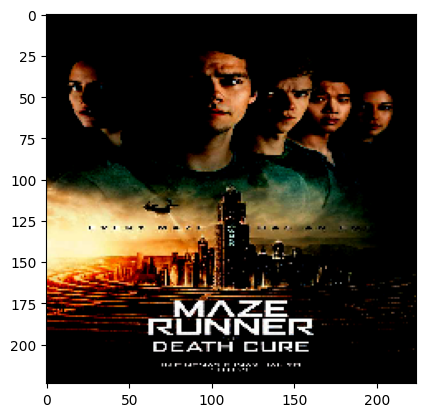

In [30]:
n=10
print(imagedata[n])
plt.imshow(imagedata[n])

In [31]:
masks[n]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

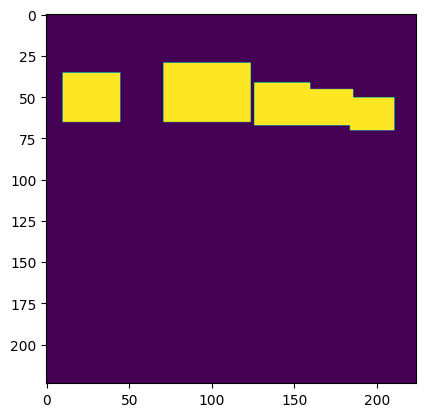

In [32]:
plt.imshow(masks[n])

Train Test Split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(imagedata, masks, test_size=0.2, random_state=42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

314 314 79 79


In [112]:
y_train.shape

(314, 224, 224)

Model Building and Evaluation:-
Design a face mask detection model - Evaluate and share insights on performance of the model - Predict and visualize the masks for the test images

Model Designing

In [34]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf

HEIGHT_CELLS = 28
WIDTH_CELLS = 28
BATCH_SIZE = 1

In [35]:
model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")
model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [43]:
def create_model1(trainable=False):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block00 = model.layers[0].input
    block01 = model.get_layer("conv_pw_1_relu").output
    block02 = model.get_layer("conv_pw_2_relu").output
    block03 = model.get_layer("conv_pw_3_relu").output
    block05 = model.get_layer("conv_pw_5_relu").output
    block11 = model.get_layer("conv_pw_11_relu").output
    block13 = model.get_layer("conv_pw_13_relu").output

    decoderBlock = Concatenate()([UpSampling2D()(block13), block11])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block05])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block03])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block01])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block00])

    decoderBlock = Conv2D(1, kernel_size=1, activation="sigmoid")(decoderBlock)
    decoderBlock = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(decoderBlock)

    return Model(inputs=model.input, outputs=decoderBlock)


In [83]:
model.layers[0]

<InputLayer name=input_layer_20, built=True>

In [90]:
def create_model(trainable=False):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    #block00 = model.layers[0]
    block00 = model.get_layer(index=0).output
    block01 = model.get_layer("conv_pw_1_relu").output
    block02 = model.get_layer("conv_pw_2_relu").output
    block03 = model.get_layer("conv_pw_3_relu").output
    block05 = model.get_layer("conv_pw_5_relu").output
    block11 = model.get_layer("conv_pw_11_relu").output
    block13 = model.get_layer("conv_pw_13_relu").output

    # Print shapes for debugging
    print("block13 shape:", block13.shape)
    print("block11 shape:", block11.shape)
    print("block05 shape:", block05.shape)
    print("block03 shape:", block03.shape)
    print("block01 shape:", block01.shape)
    print("block00 shape:", block00.shape)

    decoderBlock = Concatenate()([UpSampling2D()(block13), block11])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block05])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block03])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block01])

    # Adjust upsampling to match block00 shape if necessary
    upsample_factor = (block00.shape[1] // decoderBlock.shape[1],
                       block00.shape[2] // decoderBlock.shape[2])
    decoderBlock = UpSampling2D(size=upsample_factor)(decoderBlock)

    decoderBlock = Concatenate()([decoderBlock, block00]) # Problematic line

    decoderBlock = Conv2D(1, kernel_size=1, activation="sigmoid")(decoderBlock)
    decoderBlock = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(decoderBlock)

    return Model(inputs=model.input, outputs=decoderBlock)

In [91]:
model = create_model()
# Print summary
model.summary()

block13 shape: (None, 7, 7, 1024)
block11 shape: (None, 14, 14, 512)
block05 shape: (None, 28, 28, 256)
block03 shape: (None, 56, 56, 128)
block01 shape: (None, 112, 112, 64)
block00 shape: (None, 224, 224, 3)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_25[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 32)   │            128 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1                 │ (None, 112, 112, 32)   │            288 │ conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1_bn              │ (None, 112, 112, 32)   │            128 │ conv_dw_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1_relu (ReLU)     │ (None, 112, 112, 32)   │              0 │ conv_dw_1_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1 (Conv2D)        │ (None, 112, 112, 64)   │          2,048 │ conv_dw_1_relu[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1_bn              │ (None, 112, 112, 64)   │            256 │ conv_pw_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1_relu (ReLU)     │ (None, 112, 112, 64)   │              0 │ conv_pw_1_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pad_2                │ (None, 113, 113, 64)   │              0 │ conv_pw_1_relu[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2                 │ (None, 56, 56, 64)     │            576 │ conv_pad_2[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2_bn              │ (None, 56, 56, 64)     │            256 │ conv_dw_2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2_relu (ReLU)     │ (None, 56, 56, 64)     │              0 │ conv_dw_2_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_2 (Conv2D)        │ (None, 56, 56, 128)    │          8,192 │ conv_dw_2_relu[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_2_bn         

 Total params: 3,230,852 (12.32 MB)

 Trainable params: 1,988 (7.77 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [92]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [93]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [95]:
model = create_model(False)
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer = optimizer, metrics=[dice_coefficient])

block13 shape: (None, 7, 7, 1024)
block11 shape: (None, 14, 14, 512)
block05 shape: (None, 28, 28, 256)
block03 shape: (None, 56, 56, 128)
block01 shape: (None, 112, 112, 64)
block00 shape: (None, 224, 224, 3)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 32)   │            128 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1                 │ (None, 112, 112, 32)   │            288 │ conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1_bn              │ (None, 112, 112, 32)   │            128 │ conv_dw_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1_relu (ReLU)     │ (None, 112, 112, 32)   │              0 │ conv_dw_1_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1 (Conv2D)        │ (None, 112, 112, 64)   │          2,048 │ conv_dw_1_relu[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1_bn              │ (None, 112, 112, 64)   │            256 │ conv_pw_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1_relu (ReLU)     │ (None, 112, 112, 64)   │              0 │ conv_pw_1_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pad_2                │ (None, 113, 113, 64)   │              0 │ conv_pw_1_relu[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2                 │ (None, 56, 56, 64)     │            576 │ conv_pad_2[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2_bn              │ (None, 56, 56, 64)     │            256 │ conv_dw_2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2_relu (ReLU)     │ (None, 56, 56, 64)     │              0 │ conv_dw_2_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_2 (Conv2D)        │ (None, 56, 56, 128)    │          8,192 │ conv_dw_2_relu[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_2_bn         

 Total params: 3,230,852 (12.32 MB)

 Trainable params: 1,988 (7.77 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model Training

In [161]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,TensorBoard

reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=1, min_lr=1e-6, verbose=1, mode="min")

In [ ]:
model.fit(X_train,y_train,epochs = 5,verbose=1,batch_size=3,callbacks=[reduce_lr])

In [1]:
history = model.fit(X_train,y_train,batch_size=3,
                    steps_per_epoch=X_train.shape[0] // 3,
                    epochs=10,
                    callbacks=[reduce_lr],
                    validation_split=0.1,
                    verbose = 1)

NameError: name 'model' is not defined